# **Sampling and Selection**
## Healthcare Provider Fraud Detection - **Part 6**

In this sixth segment of my claim fraud analysis, I create four different samples for the imminent modelling. I do so by mixing applications of two techniques, oversampling from the minority class and correlation-based feature selection.

The most notable section of this work pertains to the resampling:
- [Alleviating class imbalance by oversampling from the minority](#oversampling)

<br></br>

## **Overview**

One primary goal of this analysis was to explore whether differing feature selections and sampling techniques might aid classification, specifically in the context of healthcare claim fraud.

In a preceding section, I arrived at a correlation-based feature selection. It involves retaining only two predictor attributes, *Claim_AmtTotal* and *Claim_IPShare*. In a section to shortly follow, I will employ oversampling to alleviate the class imbalance to `75-25`, from its initial ~`91-9`.

Using these techniques, I will create the following four samples for modelling:

<br></br>

| Sample Name | Name Abbv | Class rebalanced? | CFS-reduced? |
--------------|-----------|-------------------|--------------|
| Conventional Sample | `cs` | No | No |
| CFS-reduced, conventional sample | `cs_cfs` | No | Yes |
| Oversampled sample | `os` | Yes | No |
| CFS-reduced, oversampled sample | `os_cfs` | Yes | Yes |

<br></br>

When modelling is complete towards the end of this analysis, I will attempt to assess from those results the possible effects of these techniques.


### **Quick Setup**



**Importing libraries**

In [1]:
# Installing the 'imblearn' library for an oversampling method it avails
!pip install imblearn

In [2]:
import pandas as pd
import numpy as np

import pickle
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler

**Loading objects from the preceding part**

In [3]:
# Mounting my Google Drive, where I've saved the preceding part's objects to file:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Loading the objects necessary for this part

# Project directory path in Google Drive
project_dir_path = '/content/gdrive/MyDrive/fraud_data_dsc540/'

# Loading the 'df' from the preceding part, 3:
part5_filepath = project_dir_path + '/walkthrough/part_5/'

cfs_df = pd.read_pickle(f'{part5_filepath}cfs_df.pkl')

# Loading the training and testing datasets (which were finalized in part #4):
preproc_df_pkl_filepath = project_dir_path + '/walkthrough/data/preprocessed/pkl/'

X_train = pd.read_pickle(f'{preproc_df_pkl_filepath}X_train.pkl')
y_train = pd.read_pickle(f'{preproc_df_pkl_filepath}y_train.pkl')
X_test = pd.read_pickle(f'{preproc_df_pkl_filepath}X_test.pkl')
y_test = pd.read_pickle(f'{preproc_df_pkl_filepath}y_test.pkl')

# Load 'rand_st' , the random seed integer, from part #4, where it was declared:
part4_filepath = project_dir_path + '/walkthrough/part_4/'

with open(f'{part4_filepath}rand_st.pkl', 'rb') as file:
  rand_st = pickle.load(file)

### **Conventional Sample**

As mentioned, the conventional sample is merely the current working datasets, `X_train` and `y_train`. These were created towards the end of section "Data Integration II," by splitting the available data 80-20 for train and test.

I include a commented-out copy of the command that created these sets, for reference, in the next code cell:

In [5]:
# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2,
#                                                     stratify=y_all,
#                                                     random_state=rand_st)

I copy those sets to dedicated 'cs' variables, trading some memory for clarity:

In [6]:
X_train_cs = X_train.copy()
y_train_cs = y_train.copy()

X_test_cs = X_test.copy()
y_test_cs = y_test.copy()

Reviewing the shape of these datasets:

In [7]:
print(f'{X_train_cs.shape=}', f'{y_train.shape=}', '\n',
      f'{X_test_cs.shape=}', f'{y_test_cs.shape=}',
      sep = '\n')

X_train_cs.shape=(4328, 20)
y_train.shape=(4328,)


X_test_cs.shape=(1082, 20)
y_test_cs.shape=(1082,)


Examining the class balance of this conventionally split sample:

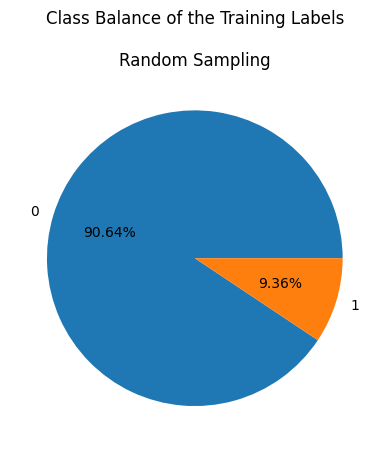

In [8]:
pie_keys = y_train.value_counts().index.tolist()
pie_vals = y_train.value_counts().values.tolist()
plt.pie(pie_vals, labels=pie_keys, autopct='%.2f%%')
plt.title('Class Balance of the Training Labels\n\nRandom Sampling')
plt.show()

Roughly 91% of the providers in this training data show '0' for _PotentialFraud_, with only 9% showing '1'. This is a degree of class imbalance that can create issues for classification. Models trained on imbalanced data tend to bias their classification in favor of the more prevalent state.

In the section shortly following, I will create a more balanced sample for training, using a technique called oversampling.

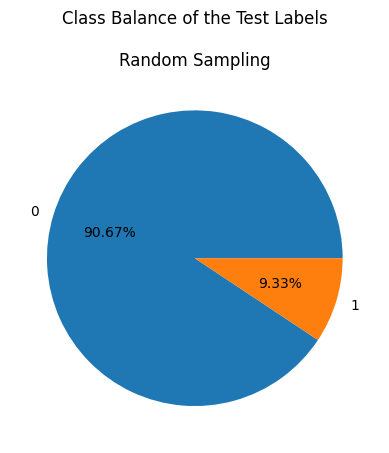

In [9]:
pie_keys = y_test.value_counts().index.tolist()
pie_vals = y_test.value_counts().values.tolist()
plt.pie(pie_vals, labels=pie_keys, autopct='%.2f%%')
plt.title('Class Balance of the Test Labels\n\nRandom Sampling')
plt.show()

The stratified sampling appears to have been successful, as the class balance is highly similar between the training and test sets.

Save these datasets to a dedicated data directory, for future reference and reproducibility:

In [11]:
preproc_data_filepath = '/content/gdrive/MyDrive/fraud_data_dsc540/walkthrough/data/preprocessed/'

# Saving this sample's datasets in pkl format
sample_file_dirpath_suffix = '/pkl/samples/cs'

!mkdir -p {preproc_data_filepath}{sample_file_dirpath_suffix}

X_train_cs.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/X_train_cs.pkl')
y_train_cs.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/y_train_cs.pkl')
X_test_cs.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/X_test_cs.pkl')
y_test_cs.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/y_test_cs.pkl')

# Saving this sample's datasets in csv format
sample_file_dirpath_suffix = '/csv/samples/cs'

!mkdir -p {preproc_data_filepath + sample_file_dirpath_suffix}

X_train_cs.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/X_train_cs.csv')
y_train_cs.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/y_train_cs.csv')
X_test_cs.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/X_test_cs.csv')
y_test_cs.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/y_test_cs.csv')


### **Conventional + CFS Sample**
#### Applying CFS to the conventionally-sampled set

In the subsection of my correlation analysis titled "Correlation-Based Feature Selection," I arrived at a selection of only two predictors. These were *Claim_AmtTotal* and *Claim_IPShare*.

To apply the reduction of this CFS to the training data, I taking the corresponding subset of attributes:

In [12]:
# The CFS-reduced data is selected from the rebalanced, 75:25 dataset.
X_train_cs_cfs = X_train_cs[['Claim_AmtTotal', 'Claim_IPShare']].copy()

# The training labels are unchanged
y_train_cs_cfs = y_train_cs.copy()

# Glancing at this reduced training data
X_train_cs_cfs.head()

,Claim_AmtTotal,Claim_IPShare
3090,25220,0.000000
3462,8320,0.000000
3446,36470,0.000000
839,148550,0.625000
921,454360,0.534091


The feature selection must also be applied to the test subset of the predictor data, while the test labels again remain the same:

In [13]:
# Create the test predictor dataset
X_test_cs_cfs = X_test_cs[['Claim_AmtTotal', 'Claim_IPShare']].copy()

# The test labels are unchanged.
y_test_cs_cfs = y_test_cs.copy()

I save these datasets to file, for future reference and reproducibility:

In [14]:
# Saving this sample's datasets in pkl format
sample_file_dirpath_suffix = '/pkl/samples/cs_cfs'
!mkdir -p {preproc_data_filepath + sample_file_dirpath_suffix}

X_train_cs_cfs.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/X_train_cs_cfs.pkl')
y_train_cs_cfs.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/y_train_cs_cfs.pkl')
X_test_cs_cfs.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/X_test_cs_cfs.pkl')
y_test_cs_cfs.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/y_test_cs_cfs.pkl')

# Saving this sample's datasets in csv format
sample_file_dirpath_suffix = '/csv/samples/cs_cfs'
!mkdir -p {preproc_data_filepath + sample_file_dirpath_suffix}

X_train_cs_cfs.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/X_train_cs_cfs.csv')
y_train_cs_cfs.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/y_train_cs_cfs.csv')
X_test_cs_cfs.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/X_test_cs_cfs.csv')
y_test_cs_cfs.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/y_test_cs_cfs.csv')

<a name="oversampling"></a>
### **Rebalanced Sample**
#### Addressing Class Imbalance

I now create a sample with better class balance. I seek to achieve 75-25 split (75% unfraudulent cases, 25% potentially fraud.) This ratio has been recommended as good starting point for rebalancing efforts.

First, for my own information, I do a little math to determine how many cases will need to be resampled from the minority class in order to achieve a 75-25 ratio:

In [15]:
potential_fraud_cases = y_train_cs.value_counts()
unflagged_case_count = potential_fraud_cases[0]
flagged_case_count = potential_fraud_cases[1]

flagged_count_needed_for_ratio = potential_fraud_cases[0]/3
resamplings_needed_count = flagged_count_needed_for_ratio - flagged_case_count

print(f'Count of cases flagged as "PotentiallyFraud": {flagged_case_count}')
print(f'Count of cases unflagged as "PotentiallyFraud": {unflagged_case_count}')
print('\nNumber of flagged cases necessary to achieve a class balance of 25-75: ',
      f'{flagged_count_needed_for_ratio:.0f}')
print('Number of resamplings of such cases necessary to achieve that: ',
      f'{resamplings_needed_count:.0f}')

Count of cases flagged as "PotentiallyFraud": 405
Count of cases unflagged as "PotentiallyFraud": 3923

Number of flagged cases necessary to achieve a class balance of 25-75:  1308
Number of resamplings of such cases necessary to achieve that:  903


To reach the desired balance, it will take `903` oversampled cases of potential fraudulence. This is more than double the number of such records that are authentic, which is `405`.

So after resampling, more than two thirds of the "PotentialFraud == 1" cases will be synthetically produced. This is a heavy bias that will be important to consider when discussing results later on.

Carrying out the resampling:

In [16]:
ros = RandomOverSampler(sampling_strategy=(1/3), random_state=rand_st)

X_train_os, y_train_os = ros.fit_resample(X_train_cs, y_train_cs)

Resampling is only performed on the data used to train the models.

The test data is left alone, but I will copy it for clarity, like I did in the previous sample:

In [17]:
X_test_os = X_test_cs.copy()
y_test_os = y_test_cs.copy()

Reviewing the shape of these datasets:

In [18]:
print(f'{X_train_os.shape=}', f'{y_train_os.shape=}', '\n',
      f'{X_test_cs.shape=}', f'{y_test_cs.shape=}',
      sep = '\n')

X_train_os.shape=(5230, 20)
y_train_os.shape=(5230,)


X_test_cs.shape=(1082, 20)
y_test_cs.shape=(1082,)


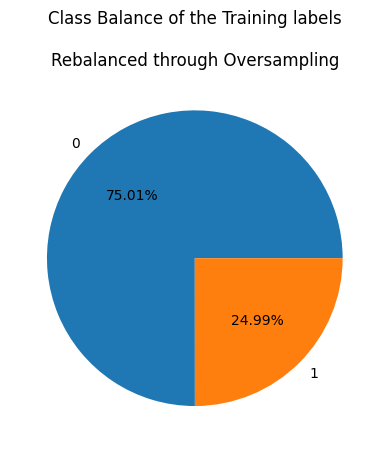

In [19]:
pie_keys = y_train_os.value_counts().index.tolist()
pie_vals = y_train_os.value_counts().values.tolist()
plt.pie(pie_vals, labels=pie_keys, autopct='%.2f%%')
plt.title('Class Balance of the Training labels\n\nRebalanced through Oversampling')
plt.show()

The oversampling appears to have been successful. With that done, I will commence the next round of modelling.

Saving these datasets to a dedicated data directory, for future reference and reproducibility:

In [20]:
# Savings this sample's datasets in pkl format
sample_file_dirpath_suffix = '/pkl/samples/os'
!mkdir -p {preproc_data_filepath + sample_file_dirpath_suffix}

X_train_os.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/X_train_os.pkl')
y_train_os.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/y_train_os.pkl')
X_test_os.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/X_test_os.pkl')
y_test_os.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/y_test_os.pkl')

# Saving this sample's datasets in csv format
sample_file_dirpath_suffix = '/csv/samples/os'
!mkdir -p {preproc_data_filepath + sample_file_dirpath_suffix}

X_train_os.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/X_train_os.csv')
y_train_os.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/y_train_os.csv')
X_test_os.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/X_test_os.csv')
y_test_os.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/y_test_os.csv')

### **Rebalanced + CFS Sample**
#### Applying CFS to the rebalanced set

In the subsection of my correlation analysis titled "Correlation-Based Feature Selection," I arrived at only two features.

For reference, I re-print those attributes (and also the target, _PotentialFraud_):

In [21]:
print(cfs_df.columns.tolist())

['Claim_AmtTotal', 'Claim_IPShare', 'PotentialFraud']


Next, I create the CFS-reduced data by taking the corresponding attribute subset of the existing oversampled data (from the previous section):

In [22]:
# The CFS-reduced data is selected from the rebalanced, 75:25 dataset.
X_train_os_cfs = X_train_os[['Claim_AmtTotal', 'Claim_IPShare']].copy()

# The training labels are unchanged
y_train_os_cfs = y_train_os.copy()

# Glancing at this reduced, oversampled training data
X_train_os_cfs.head()

,Claim_AmtTotal,Claim_IPShare
0,25220,0.000000
1,8320,0.000000
2,36470,0.000000
3,148550,0.625000
4,454360,0.534091


The feature selection must also be applied to the test set of predictor data, while the test labels again remain the same:

In [23]:
# Create the test predictor dataset
X_test_os_cfs = X_test_os[['Claim_AmtTotal', 'Claim_IPShare']].copy()

# The test labels are unchanged.
y_test_os_cfs = y_test_os.copy()

Saving these to a dedicated data directory, for future reference and reproducibility.

In [24]:
# Saving this sample's datasets in pkl format
sample_file_dirpath_suffix = '/pkl/samples/os_cfs'
!mkdir -p {preproc_data_filepath + sample_file_dirpath_suffix}

X_train_os_cfs.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/X_train_os_cfs.pkl')
y_train_os_cfs.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/y_train_os_cfs.pkl')
X_test_os_cfs.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/X_test_os_cfs.pkl')
y_test_os_cfs.to_pickle(preproc_data_filepath + sample_file_dirpath_suffix + '/y_test_os_cfs.pkl')

# Saving this sample's datasets in csv format
sample_file_dirpath_suffix = '/csv/samples/os_cfs'
!mkdir -p {preproc_data_filepath + sample_file_dirpath_suffix}

X_train_os_cfs.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/X_train_os_cfs.csv')
y_train_os_cfs.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/y_train_os_cfs.csv')
X_test_os_cfs.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/X_test_os_cfs.csv')
y_test_os_cfs.to_csv(preproc_data_filepath + sample_file_dirpath_suffix + '/y_test_os_cfs.csv')



---




Now that I have created and saved the various sample sets, I can begin the modelling in the next section.